In [1]:
# importing relevant dependencies & libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

%matplotlib inline
import warnings
warnings.simplefilter('ignore')

In [2]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
#path to data
houses = pd.read_csv('Resources/home_data.csv')

In [6]:
# inspecting houses file
houses.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650.0,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242.0,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000.0,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


Exploratory Data Analysis (EDA)

Performing an effective EDA can reveal insights about the data that can be used to help identify necessary data cleaning steps before testing and building a model.

First, identify null values in the data set, and explore the summary statistics for each column available. 

In [7]:
def kcounty_eda(df): 
    eda_df = {}
    eda_df['null_sum'] = df.isnull().sum()
    eda_df['null_pct'] = df.isnull().mean()
    eda_df['dtypes'] = df.dtypes
    eda_df['count'] = df.count()
    eda_df['mean'] = df.mean()
    eda_df['median'] = df.median()
    eda_df['min'] = df.min()
    eda_df['max'] = df.max()
    
    return pd.DataFrame(eda_df)

kcounty_eda(houses)

,null_sum,null_pct,dtypes,count,mean,median,min,max
bathrooms,0,0.0,float64,21613,2.114757e+00,2.250000e+00,0,8
bedrooms,0,0.0,int64,21613,3.370842e+00,3.000000e+00,0,33
condition,0,0.0,int64,21613,3.409430e+00,3.000000e+00,1,5
date,0,0.0,object,21613,NaN,NaN,20140502T000000,20150527T000000
floors,0,0.0,float64,21613,1.494309e+00,1.500000e+00,1,3.5
grade,0,0.0,int64,21613,7.656873e+00,7.000000e+00,1,13
id,0,0.0,int64,21613,4.580302e+09,3.904930e+09,1000102,9900000190
lat,0,0.0,float64,21613,4.756005e+01,4.757180e+01,47.1559,47.7776
long,0,0.0,float64,21613,-1.222139e+02,-1.222300e+02,-122.519,-121.315
price,0,0.0,float64,21613,5.400881e+05,4.500000e+05,75000,7.7e+06


In [8]:
#nspect what other column types there are.
houses.dtypes.value_counts()

int64      14
float64     6
object      1
dtype: int64

In [9]:
# returns list of my object columns
houses.select_dtypes(include=['object']).columns

Index(['date'], dtype='object')

Exploring relationships with our target:

Another part of EDA is to explore whether there is a relationship between our potential feature columns and our target, the home sale price.

Pandas' corrwith method will return a pair-wise correlation for each feature with the home price.

Using seaborn, we can visualize these pair-wise correlations. For ease of analysis, the code below sorts the pair-wise correlations by absolute value.

This easily identifies features such as the overall quality of the home and the size of the living area have a strong relationship with the sale price.

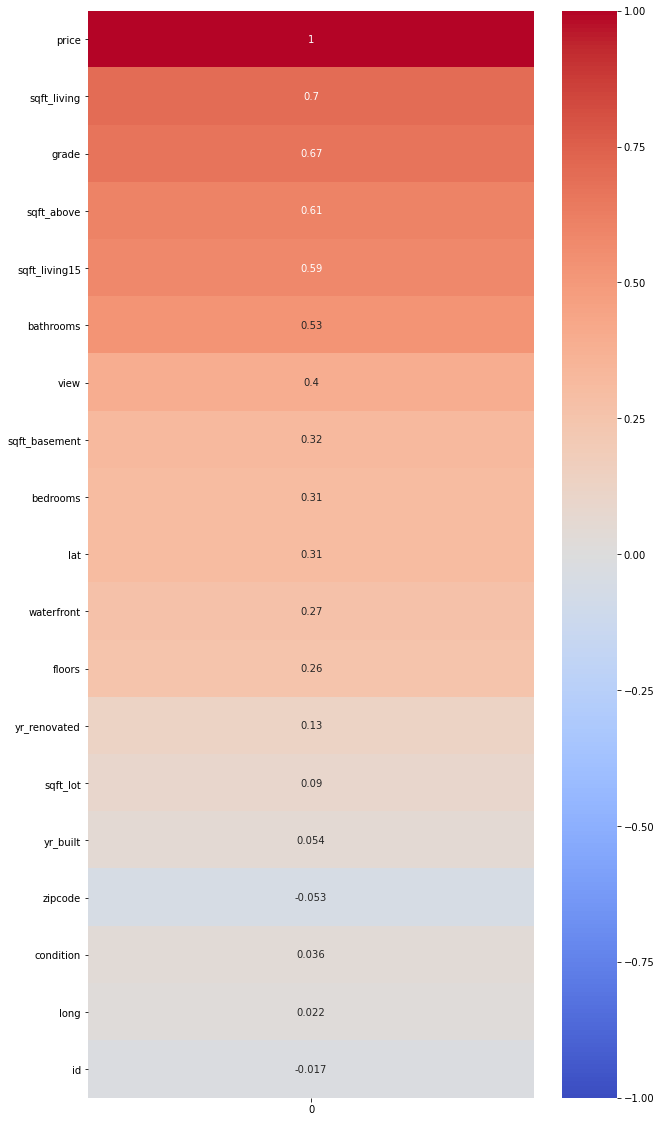

In [10]:
correlations = houses.corrwith(houses['price']).iloc[:-1].to_frame()
correlations['abs'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('abs', ascending=False)[0]

fig, ax = plt.subplots(figsize=(10,20))
sns.heatmap(sorted_correlations.to_frame(), \
            cmap='coolwarm', annot=True, vmin=-1, vmax=1, ax=ax);

Complete Multiple Regressions to identiy valuable Feature(s) - should be in line with the above correlations heatmap

In [14]:
#MLR 1:
#Setting X and y variables for Linear Regression Model: 2 Features
X = houses[['sqft_above','sqft_living','grade']] 
y = houses['price'].values.reshape(-1,1)
print(X.shape, y.shape)

(21613, 3) (21613, 1)


In [16]:
X

,sqft_above,sqft_living,grade
0,1180,1180,7
1,2170,2570,7
2,770,770,6
3,1050,1960,7
4,1680,1680,8
...,...,...,...
21608,1530,1530,8
21609,2310,2310,8
21610,1020,1020,7
21611,1600,1600,8


In [17]:
# Use train_test_split to create training and testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [18]:
X_train

,sqft_above,sqft_living,grade
5945,1810,1810,7
8423,1600,1600,7
13488,1720,1720,8
20731,1150,1240,7
2358,1280,1280,7
...,...,...,...
11964,1000,1000,7
21575,3087,3087,8
5390,2120,2120,7
860,380,380,5


In [19]:
 # Create the model using LinearRegression
model = LinearRegression()

In [20]:
# Fit the model to the training data and calculate the scores for the training and testing data
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.5387853851580333
Testing Score: 0.5463919491616227


Text(0.5, 1.0, 'Residual Plot')

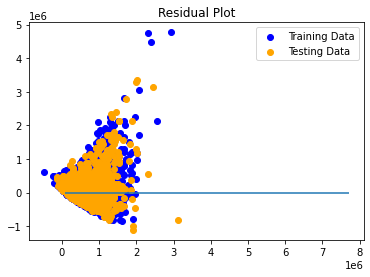

In [21]:
# Plot the Residuals for the Training and Testing data

plt.scatter(model.predict(X_train), y_train - model.predict(X_train), c="blue", label="Training Data")
plt.scatter(model.predict(X_test), y_test - model.predict(X_test), c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")


In [27]:
#MLR 2:
#Setting X and y variables for Linear Regression Model: 3 Features
X = houses[['bedrooms','bathrooms','floors']] 
y = houses['price'].values.reshape(-1,1)
print(X.shape, y.shape)

(21613, 3) (21613, 1)


In [53]:
# Use train_test_split to create training and testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [54]:
 # Create the model using LinearRegression
model = LinearRegression()

In [55]:
# Fit the model to the training data and calculate the scores for the training and testing data

model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.5491498983751539
Testing Score: 0.5583966471204458


Text(0.5, 1.0, 'Residual Plot')

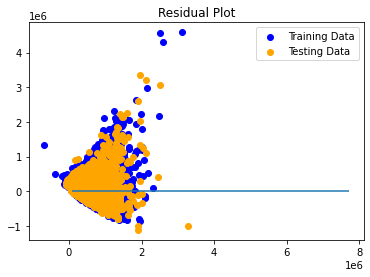

In [56]:
# Plot the Residuals for the Training and Testing data

plt.scatter(model.predict(X_train), y_train - model.predict(X_train), c="blue", label="Training Data")
plt.scatter(model.predict(X_test), y_test - model.predict(X_test), c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")

In [62]:
#MRR 3:
#Setting X and y variables for Linear Regression Model: 5 Features
X = houses[['bedrooms','bathrooms','sqft_living','zipcode','grade']] 
y = houses['price'].values.reshape(-1,1)
print(X.shape, y.shape)

(21613, 5) (21613, 1)


In [63]:
# Use train_test_split to create training and testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [59]:
#Create the model using LinearRegression
 model = LinearRegression()

In [64]:
# Fit the model to the training data and calculate the scores for the training and testing data

model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.5491498983751539
Testing Score: 0.5583966471204458


Text(0.5, 1.0, 'Residual Plot')

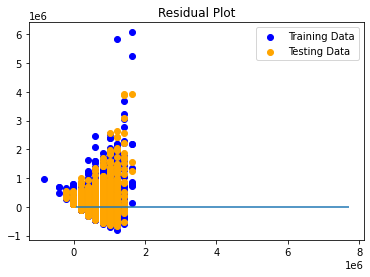

In [61]:
# Plot the Residuals for the Training and Testing data

plt.scatter(model.predict(X_train), y_train - model.predict(X_train), c="blue", label="Training Data")
plt.scatter(model.predict(X_test), y_test - model.predict(X_test), c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")

In [65]:
#scale the data (standard)
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)


In [66]:
# Transform the training and testing data using the X_scaler and y_scaler models

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [67]:
  # Create a LinearRegression model and fit it to the scaled training data

model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [68]:
# Fit the model to the training data and calculate the scores for the training and testing data

model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.5491498983751539
Testing Score: 0.5583966471204458


Plot Original Data vs. Scaled Data

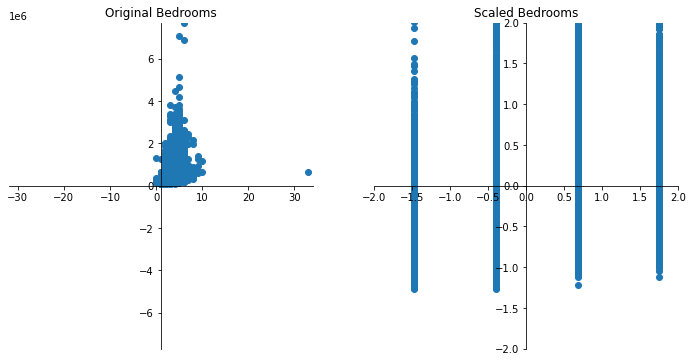

In [43]:
#Bedrooms
fig1 = plt.figure(figsize=(12, 6))
axes1 = fig1.add_subplot(1, 2, 1)
axes2 = fig1.add_subplot(1, 2, 2)

axes1.set_title("Original Bedrooms")
axes2.set_title("Scaled Bedrooms")

maxx = X_train["bedrooms"].max()
maxy = y_train.max()
axes1.set_xlim(-maxx + 1, maxx + 1)
axes1.set_ylim(-maxy + 1, maxy + 1)

axes2.set_xlim(-2, 2)
axes2.set_ylim(-2, 2)

def set_axes(ax):
    ax.spines['left'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('center')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
set_axes(axes1)
set_axes(axes2)

axes1.scatter(X_train["bedrooms"], y_train)
axes2.scatter(X_train_scaled[:,0], y_train_scaled[:])

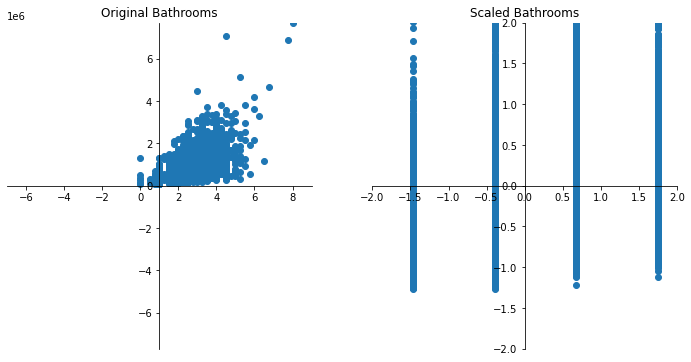

In [44]:
#Bathrooms
fig1 = plt.figure(figsize=(12, 6))
axes1 = fig1.add_subplot(1, 2, 1)
axes2 = fig1.add_subplot(1, 2, 2)

axes1.set_title("Original Bathrooms")
axes2.set_title("Scaled Bathrooms")

maxx = X_train["bathrooms"].max()
maxy = y_train.max()
axes1.set_xlim(-maxx + 1, maxx + 1)
axes1.set_ylim(-maxy + 1, maxy + 1)

axes2.set_xlim(-2, 2)
axes2.set_ylim(-2, 2)

def set_axes(ax):
    ax.spines['left'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('center')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
set_axes(axes1)
set_axes(axes2)

axes1.scatter(X_train["bathrooms"], y_train)
axes2.scatter(X_train_scaled[:,0], y_train_scaled[:])

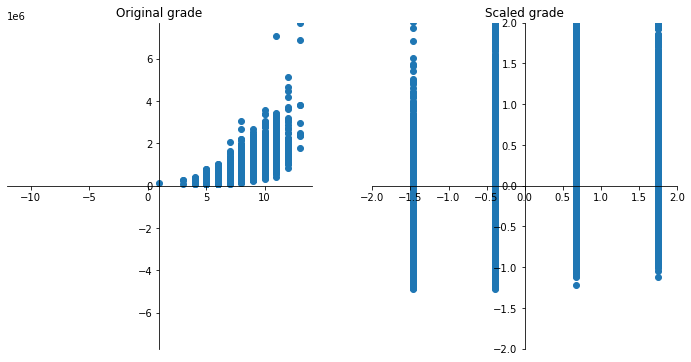

In [46]:
#Condition
fig1 = plt.figure(figsize=(12, 6))
axes1 = fig1.add_subplot(1, 2, 1)
axes2 = fig1.add_subplot(1, 2, 2)

axes1.set_title("Original grade")
axes2.set_title("Scaled grade")

maxx = X_train["grade"].max()
maxy = y_train.max()
axes1.set_xlim(-maxx + 1, maxx + 1)
axes1.set_ylim(-maxy + 1, maxy + 1)

axes2.set_xlim(-2, 2)
axes2.set_ylim(-2, 2)

def set_axes(ax):
    ax.spines['left'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('center')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
set_axes(axes1)
set_axes(axes2)

axes1.scatter(X_train["grade"], y_train)
axes2.scatter(X_train_scaled[:,0], y_train_scaled[:])

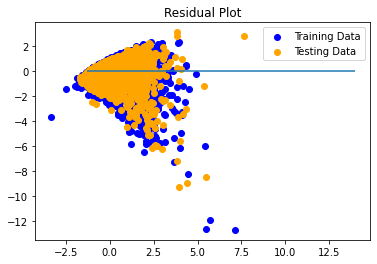

In [47]:
# Make predictions using a fitted model
# Plot the difference between the model predicted values and actual y values, versus the model predicted values

predictions = model.predict(X_test_scaled)
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()

In [48]:
#create the model with scaled data
model = LinearRegression()

# Fitting our model with all of our features in X
model.fit(X, y)

score = model.score(X, y)
print(f"R2 Score: {score}")


R2 Score: 0.55189818593706


In [49]:
# Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.5088826838668604, R2: -3590330742963645.0


Create, Fit & Score the data with the variety of Models available to show the simular result

In [50]:
# create a LASSO model
# Note: Use an alpha of .01 when creating the model for this activity

lasso = Lasso(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = lasso.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = lasso.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.5121938983488294, R2: 0.5555232079886031


In [51]:
# create a Ridge model
# Note: Use an alpha of .01 when creating the model for this activity

ridge = Ridge(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = ridge.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = ridge.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.508882716462578, R2: 0.5583966188342062


In [52]:
 # Create the model using LinearRegression
model = LinearRegression()

# Fitting our model with all of our features in X
model.fit(X, y)

score = model.score(X, y)
print(f"R2 Score: {score}")

R2 Score: 0.55189818593706
